<a href="https://colab.research.google.com/github/ClemButterscotch/SROP/blob/main/SROP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# Function to load MNIST data from files, with paths adjusted for your setup
def load_mnist_data(fashion=False):
    '''
    Load MNIST or FashionMNIST dataset from files.
    If fashion=True, load FashionMNIST dataset instead of MNIST.
    '''
    dataset_name = 'FashionMNIST' if fashion else 'MNIST'

    # Check if we have the dataset in the data folder directly
    direct_path_exists = os.path.exists('data/train-images-idx3-ubyte')

    # Define file paths based on folder structure
    if direct_path_exists:
        train_img_path = 'train-images-idx3-ubyte'
        train_lbl_path = 'train-labels-idx1-ubyte'
        test_img_path = 't10k-images-idx3-ubyte'
        test_lbl_path = 't10k-labels-idx1-ubyte'
    else:
        # Try the subfolder structure
        train_img_path = f'{dataset_name}/raw/train-images-idx3-ubyte'
        train_lbl_path = f'{dataset_name}/raw/train-labels-idx1-ubyte'
        test_img_path = f'{dataset_name}/raw/t10k-images-idx3-ubyte'
        test_lbl_path = f'{dataset_name}/raw/t10k-labels-idx1-ubyte'

        # If the files are still gzipped, extract them
        for file_path in [train_img_path, train_lbl_path, test_img_path, test_lbl_path]:
            gz_path = f"{file_path}.gz"
            if os.path.exists(gz_path) and not os.path.exists(file_path):
                with gzip.open(gz_path, 'rb') as f_in:
                    with open(file_path, 'wb') as f_out:
                        f_out.write(f_in.read())
                print(f"Extracted {gz_path} to {file_path}")

    # Load training images
    with open(train_img_path, 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        Xtraindata = np.transpose(data.reshape((size, nrows*ncols)))

    # Load training labels
    with open(train_lbl_path, 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        ytrainlabels = data.reshape((size,))

    # Load test images
    with open(test_img_path, 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        Xtestdata = np.transpose(data.reshape((size, nrows*ncols)))

    # Load test labels
    with open(test_lbl_path, 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        ytestlabels = data.reshape((size,))

    print(f"Successfully loaded {dataset_name} dataset!")
    print(f"Training data shape: {Xtraindata.shape}")
    print(f"Training labels shape: {ytrainlabels.shape}")
    print(f"Test data shape: {Xtestdata.shape}")
    print(f"Test labels shape: {ytestlabels.shape}")

    return Xtraindata, ytrainlabels, Xtestdata, ytestlabels

# Try to load MNIST data first, if it fails, fall back to FashionMNIST
try:
    print("Attempting to load MNIST dataset...")
    Xtraindata, ytrainlabels, Xtestdata, ytestlabels = load_mnist_data(fashion=True)
except FileNotFoundError:
    print("MNIST dataset not found, trying FashionMNIST instead...")
    Xtraindata, ytrainlabels, Xtestdata, ytestlabels = load_mnist_data(fashion=True)
    print("Note: Using FashionMNIST dataset instead of MNIST. The tasks will work the same way, but the digits are now clothing items.")

# Reshape for visualization
traindata_imgs = np.transpose(Xtraindata).reshape((60000, 28, 28))

Attempting to load MNIST dataset...
Successfully loaded FashionMNIST dataset!
Training data shape: (784, 60000)
Training labels shape: (60000,)
Test data shape: (784, 10000)
Test labels shape: (10000,)


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import os
import gzip
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [27]:
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader

# # Automatically downloads if not present
# mnist = datasets.MNIST(root='.', download=True, train=True,
#                        transform=transforms.ToTensor())

# loader = DataLoader(mnist, batch_size=64, shuffle=True)


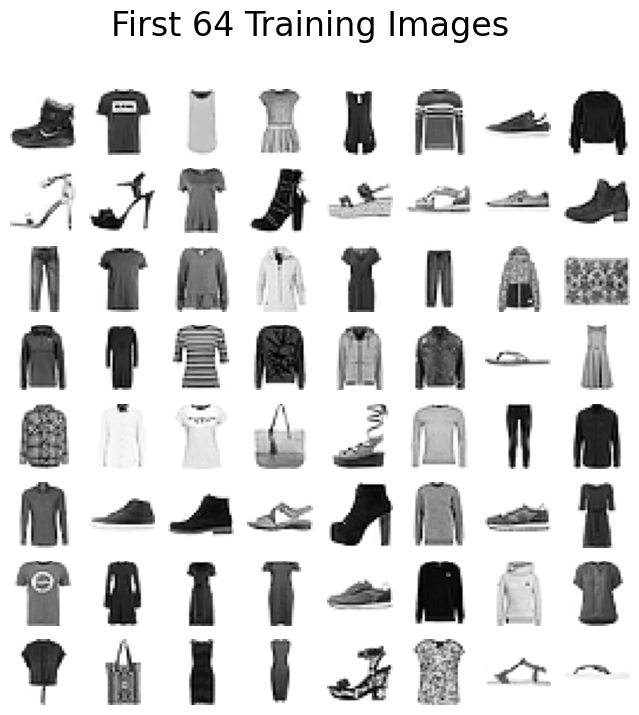

In [28]:
def plot_digits(XX, N, title):
    fig, ax = plt.subplots(N, N, figsize=(8, 8))

    for i in range(N):
      for j in range(N):
        ax[i,j].imshow(XX[:,(N)*i+j].reshape((28, 28)), cmap="Greys")
        ax[i,j].axis("off")
    fig.suptitle(title, fontsize=24)

plot_digits(Xtraindata, 8, "First 64 Training Images" )


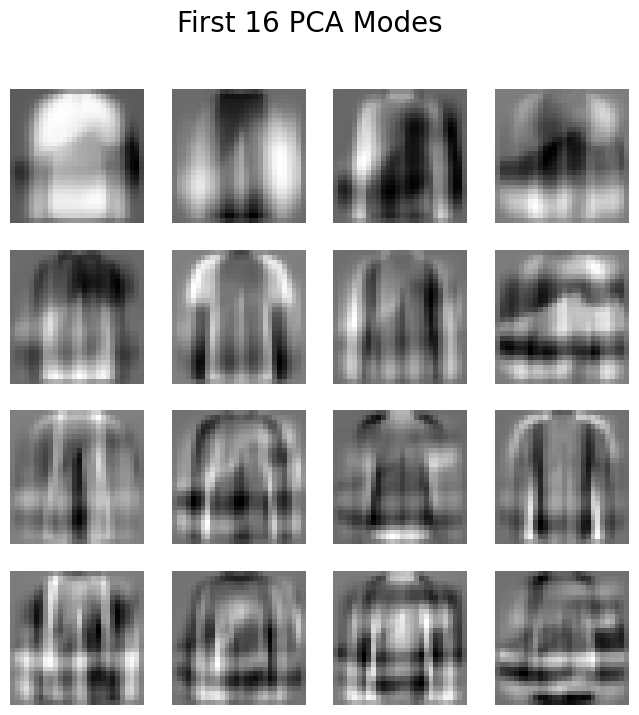

In [29]:
Xtrain = Xtraindata.T

pca = PCA()
pca.fit(Xtrain)
pc_modes = pca.components_[:16]

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i in range(4):
    for j in range(4):
        idx = i * 4 + j
        axs[i, j].imshow(pc_modes[idx].reshape(28, 28), cmap="gray")
        axs[i, j].axis("off")
fig.suptitle("First 16 PCA Modes", fontsize=20)
plt.show()


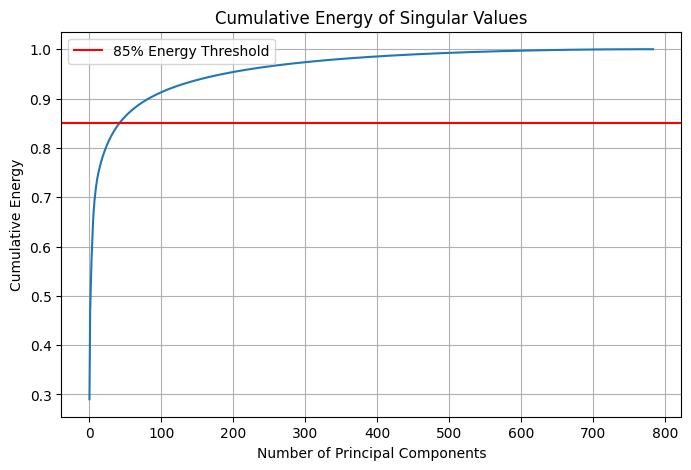

Number of PC modes needed to capture at least 85% of the energy: 43


In [30]:
Sigma = pca.singular_values_

energy = np.power(Sigma, 2) / np.sum(np.power(Sigma, 2))
cumulative_energy = np.cumsum(energy)

plt.figure(figsize=(8, 5))
plt.plot(cumulative_energy)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Energy')
plt.title('Cumulative Energy of Singular Values')
plt.axhline(y=0.85, color='r', linestyle='-', label='85% Energy Threshold')
plt.legend()
plt.grid(True)
plt.show()


k = np.argmax(cumulative_energy >= 0.85) + 1
print("Number of PC modes needed to capture at least 85% of the energy:", k)


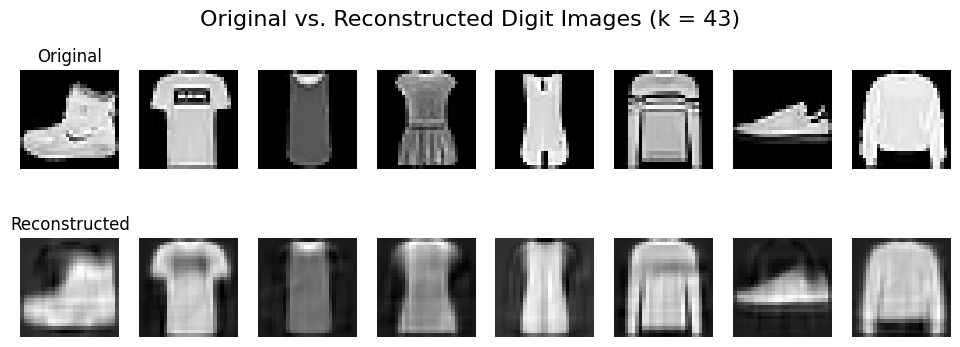

In [31]:
pca_k = PCA(n_components=k)
Xtrain_reduced = pca_k.fit_transform(Xtrain)
Xtrain_reconstructed = pca_k.inverse_transform(Xtrain_reduced)

num_images = 8
fig, axs = plt.subplots(2, num_images, figsize=(num_images * 1.5, 4))
for i in range(num_images):
    axs[0, i].imshow(Xtrain[i].reshape(28, 28), cmap="gray")
    axs[0, i].axis("off")
    if i == 0:
        axs[0, i].set_title("Original", fontsize=12)
    # Reconstruction below
    axs[1, i].imshow(Xtrain_reconstructed[i].reshape(28, 28), cmap="gray")
    axs[1, i].axis("off")
    if i == 0:
        axs[1, i].set_title("Reconstructed", fontsize=12)

fig.suptitle("Original vs. Reconstructed Digit Images (k = {})".format(k), fontsize=16)
plt.show()


In [32]:
def select_digits(X_train, y_train, X_test, y_test, digits):
    # Here we select training subset
    train_mask = np.isin(y_train, digits)
    X_subtrain = X_train[train_mask]
    y_subtrain = y_train[train_mask]

    # And here the test subset teehee
    test_mask = np.isin(y_test, digits)
    X_subtest = X_test[test_mask]
    y_subtest = y_test[test_mask]

    return X_subtrain, y_subtrain, X_subtest, y_subtest

In [33]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

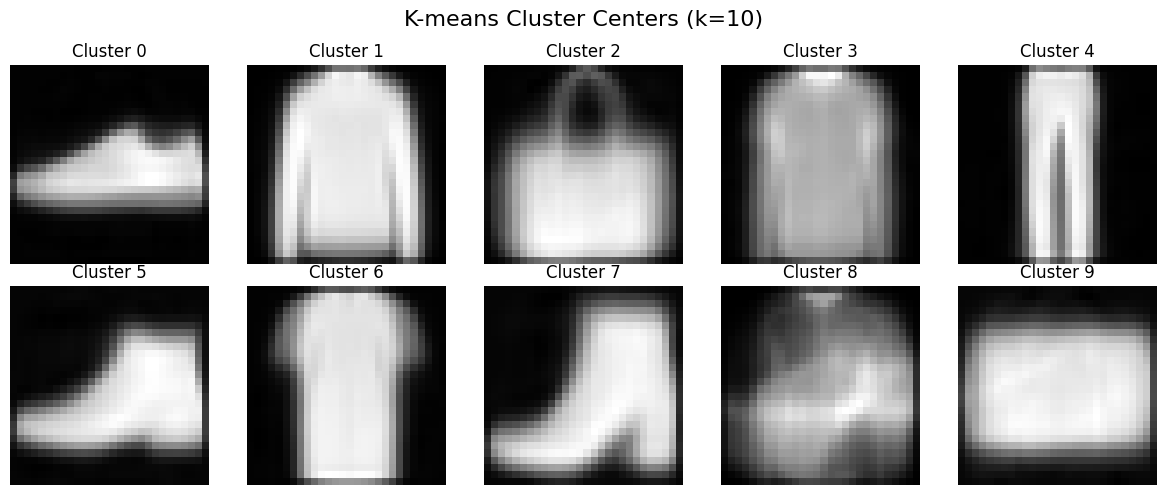

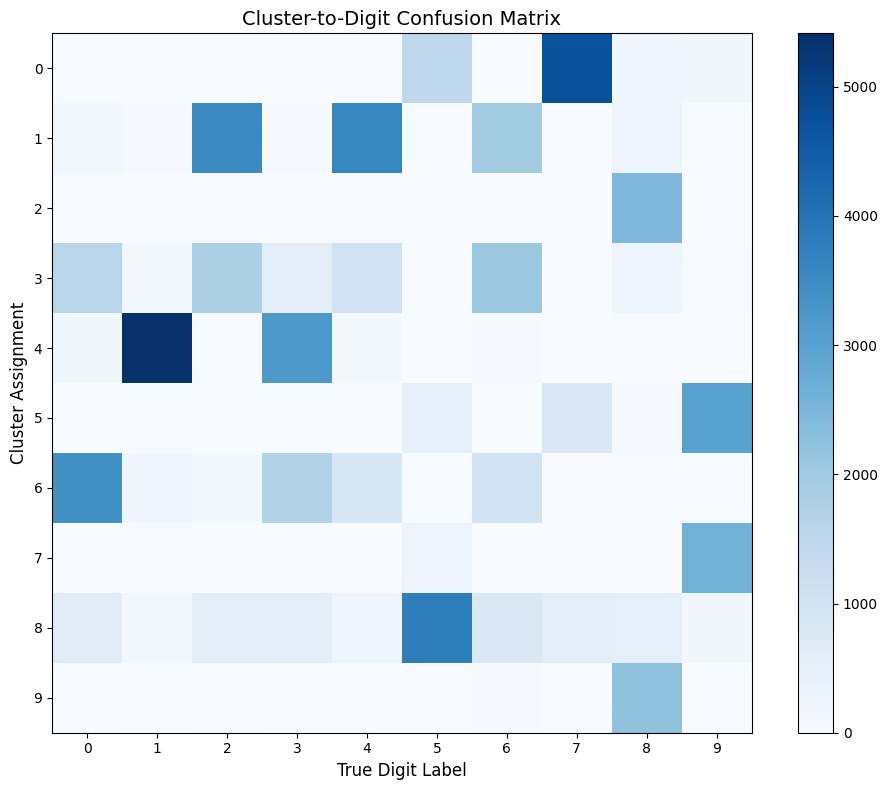

K-means clustering accuracy: 0.554


In [34]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm

# Apply K-means on PCA-reduced data
n_clusters = 10  # Since we have 10 digits/classes
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(Xtrain)

# Visualize cluster centers as images
centers = kmeans.cluster_centers_
# Project the cluster centers through PCA for better visualization
# First transform centers to PCA space, then back to image space
centers_pca = pca_k.transform(centers)
reconstructed_centers = pca_k.inverse_transform(centers_pca)

# Plot the reconstructed cluster centers
plt.figure(figsize=(12, 5))
for i in range(n_clusters):
    plt.subplot(2, 5, i+1)
    plt.imshow(reconstructed_centers[i].reshape(28, 28), cmap="gray")
    plt.title(f'Cluster {i}')
    plt.axis('off')
plt.suptitle('K-means Cluster Centers (k=10)', fontsize=16)
plt.tight_layout()
plt.show()

# Evaluate clusters by comparing with true labels
from scipy.stats import mode

# For each cluster, find the most common digit
clusters_to_digits = {}
for i in range(n_clusters):
    mask = (cluster_labels == i)
    cluster_labels_true = ytrainlabels[mask]
    if len(cluster_labels_true) > 0:
        mode_result = mode(cluster_labels_true)
        # Handle both array and scalar cases
        if hasattr(mode_result[0], '__iter__'):
            most_common = mode_result[0][0]
        else:
            most_common = mode_result[0]
        clusters_to_digits[i] = most_common

# Create a confusion matrix between clusters and true labels
cluster_confusion = np.zeros((n_clusters, 10), dtype=int)
for i, true_label in enumerate(ytrainlabels):
    cluster = cluster_labels[i]
    cluster_confusion[cluster, true_label] += 1

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cluster_confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Cluster-to-Digit Confusion Matrix', fontsize=14)
plt.colorbar()
plt.xlabel('True Digit Label', fontsize=12)
plt.ylabel('Cluster Assignment', fontsize=12)
plt.xticks(range(10))
plt.yticks(range(n_clusters))
plt.tight_layout()
plt.show()

# Calculate clustering accuracy (using the most common digit in each cluster)
correct = 0
for i, label in enumerate(ytrainlabels):
    cluster = cluster_labels[i]
    if clusters_to_digits.get(cluster) == label:
        correct += 1
clustering_accuracy = correct / len(ytrainlabels)
print(f"K-means clustering accuracy: {clustering_accuracy:.3f}")

1 vs 8 - CV Accuracy: 0.994, Test Accuracy: 0.992
Classification Report:


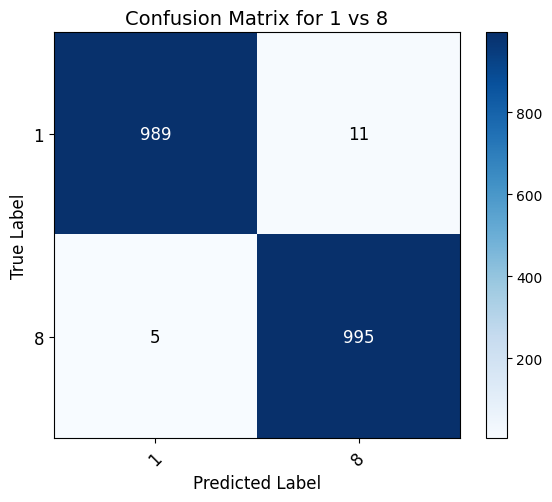

In [35]:
digits = [1, 8]
X_subtrain, y_subtrain, X_subtest, y_subtest = select_digits(Xtrain, ytrainlabels, Xtestdata.T, ytestlabels, digits)
X_subtrain_pca = pca_k.transform(X_subtrain)
X_subtest_pca = pca_k.transform(X_subtest)

ridge_clf = RidgeClassifier()
cv_scores = cross_val_score(ridge_clf, X_subtrain_pca, y_subtrain, cv=5)
ridge_clf.fit(X_subtrain_pca, y_subtrain)
test_acc = ridge_clf.score(X_subtest_pca, y_subtest)
y_pred = ridge_clf.predict(X_subtest_pca)
cm = confusion_matrix(y_subtest, y_pred)

print(f"1 vs 8 - CV Accuracy: {cv_scores.mean():.3f}, Test Accuracy: {test_acc:.3f}")
print("Classification Report:")
# print(classification_report(y_subtest, y_pred))
plot_confusion_matrix(cm, classes=digits, title='Confusion Matrix for 1 vs 8')


3 vs 8 - CV Accuracy: 0.984, Test Accuracy: 0.983
Classification Report:


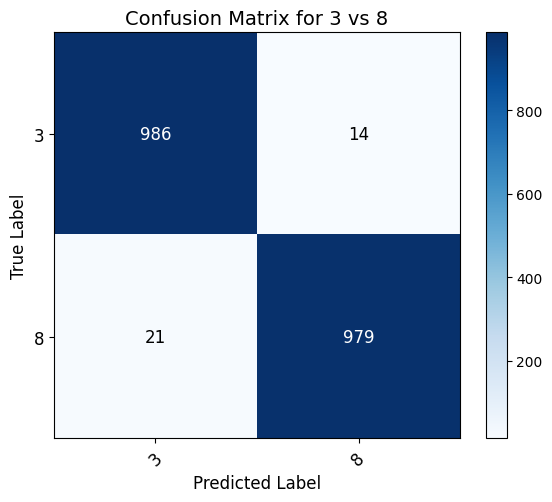

2 vs 7 - CV Accuracy: 0.999, Test Accuracy: 1.000
Classification Report:


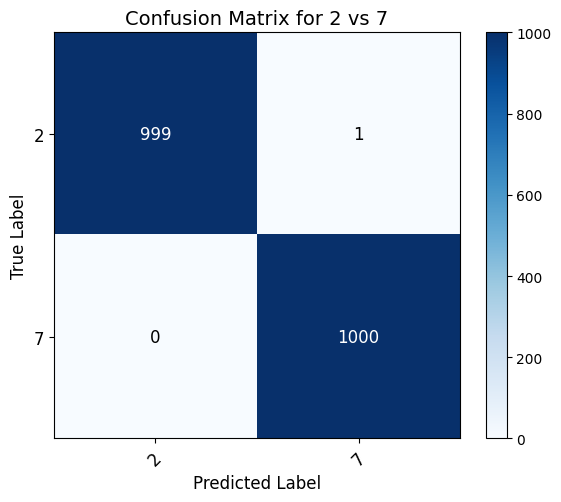

In [36]:
for pair in [[3, 8], [2, 7]]:
    X_subtrain, y_subtrain, X_subtest, y_subtest = select_digits(Xtrain, ytrainlabels, Xtestdata.T, ytestlabels, pair)
    X_subtrain_pca = pca_k.transform(X_subtrain)
    X_subtest_pca = pca_k.transform(X_subtest)

    ridge_clf = RidgeClassifier()
    cv_scores = cross_val_score(ridge_clf, X_subtrain_pca, y_subtrain, cv=5)
    ridge_clf.fit(X_subtrain_pca, y_subtrain)
    test_acc = ridge_clf.score(X_subtest_pca, y_subtest)
    y_pred = ridge_clf.predict(X_subtest_pca)
    cm = confusion_matrix(y_subtest, y_pred)

    print(f"{pair[0]} vs {pair[1]} - CV Accuracy: {cv_scores.mean():.3f}, Test Accuracy: {test_acc:.3f}")
    print("Classification Report:")
    # print(classification_report(y_subtest, y_pred))
    plot_confusion_matrix(cm, classes=pair, title=f'Confusion Matrix for {pair[0]} vs {pair[1]}')


Ridge (Multi-class) - CV Accuracy: 0.783, Test Accuracy: 0.773
KNN (Multi-class) - CV Accuracy: 0.856, Test Accuracy: 0.857


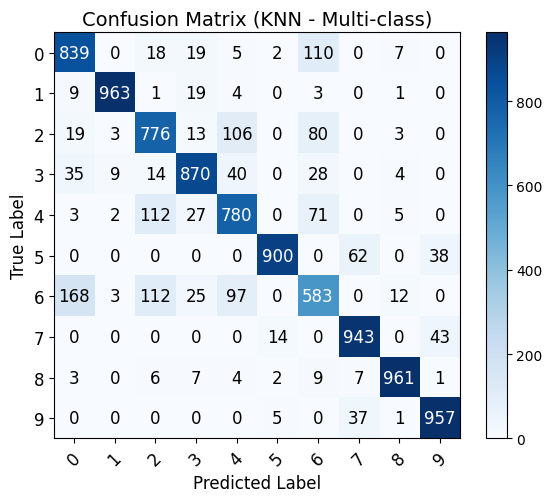

In [37]:
Xtrain_pca = pca_k.transform(Xtrain)
Xtest_pca = pca_k.transform(Xtestdata.T)

# Ridge Classifier (Multi-class)!!
ridge = RidgeClassifier()
ridge_cv = cross_val_score(ridge, Xtrain_pca, ytrainlabels, cv=5)
ridge.fit(Xtrain_pca, ytrainlabels)
ridge_acc = ridge.score(Xtest_pca, ytestlabels)
print(f"Ridge (Multi-class) - CV Accuracy: {ridge_cv.mean():.3f}, Test Accuracy: {ridge_acc:.3f}")

# KNN Classifier (Multi-class)!!
knn = KNeighborsClassifier(n_neighbors=5)
knn_cv = cross_val_score(knn, Xtrain_pca, ytrainlabels, cv=5)
knn.fit(Xtrain_pca, ytrainlabels)
knn_acc = knn.score(Xtest_pca, ytestlabels)
print(f"KNN (Multi-class) - CV Accuracy: {knn_cv.mean():.3f}, Test Accuracy: {knn_acc:.3f}")
# Taken from scikit learn documentation
y_pred_knn = knn.predict(Xtest_pca)
cm_multi = confusion_matrix(ytestlabels, y_pred_knn)
classes = np.unique(ytestlabels)
plot_confusion_matrix(cm_multi, classes=classes, title='Confusion Matrix (KNN - Multi-class)')

In [ ]:
from sklearn.cluster import SpectralClustering
from scipy.stats import mode

# Spectral Clustering (Treating as classification via cluster mapping)
n_clusters = 10 # Number of digits
# Note: SpectralClustering can be computationally expensive on large datasets.
# Consider reducing data size or using affinity='nearest_neighbors' for larger scale.
spectral = SpectralClustering(n_clusters=n_clusters, random_state=42, assign_labels='kmeans', affinity='rbf')
# Fit on training data
train_cluster_labels = spectral.fit_predict(Xtrain_pca)

# Map clusters to digits based on training data (like K-means evaluation)
clusters_to_digits_spectral = {}
for i in range(n_clusters):
    mask = (train_cluster_labels == i)
    cluster_labels_true = ytrainlabels[mask]
    if len(cluster_labels_true) > 0:
        mode_result = mode(cluster_labels_true)
        # Handle potential multiple modes
        most_common = mode_result[0][0] if hasattr(mode_result[0], '__iter__') else mode_result[0]
        clusters_to_digits_spectral[i] = most_common
    else:
        # Handle empty clusters if they occur, assign a default or skip
        clusters_to_digits_spectral[i] = -1 # Placeholder for empty cluster

# Predict cluster labels for test data
# Re-fitting is needed as predict is not standard for SpectralClustering unless affinity is precomputed
# A common approach is to train a classifier (like KNN) on train_cluster_labels
# Or, for simplicity here, we map test points based on their cluster assignment if we were to fit on all data (less ideal)
# A better approach: Use the mapping found on train set to evaluate test set accuracy
# We need to assign test points to the *existing* clusters.
# One way: Train a KNN classifier on Xtrain_pca with train_cluster_labels
knn_cluster_classifier = KNeighborsClassifier(n_neighbors=5)
knn_cluster_classifier.fit(Xtrain_pca, train_cluster_labels)
test_cluster_labels = knn_cluster_classifier.predict(Xtest_pca)

# Calculate 'accuracy' on test set using the mapping
spectral_y_pred_test = np.array([clusters_to_digits_spectral.get(label, -1) for label in test_cluster_labels])
spectral_acc = np.mean(spectral_y_pred_test == ytestlabels)
print(f"Spectral Clustering (Mapped) - Test Accuracy: {spectral_acc:.3f}")
# Note: CV accuracy is not directly calculated here as it's less standard for clustering.

In [ ]:
print("--- Final Test Accuracies ---")
print(f"Ridge Classifier:      {ridge_acc:.3f}")
print(f"KNN Classifier (k=5):  {knn_acc:.3f}")
print(f"Spectral Clustering:   {spectral_acc:.3f}") # Added spectral accuracy

Ridge Test Accuracy: 0.773
KNN   Test Accuracy: 0.857
